# 06 — Activations and Losses

Purpose: implement common activations (ReLU, sigmoid, tanh) and losses (MSE, MAE, BCE, softmax cross-entropy) with correct pairings and numerically stable softmax cross-entropy (log-sum-exp).

## Learning goals
- Plot activation functions and their derivatives.
- Understand saturation and gradient issues (sigmoid/tanh) vs ReLU behavior.
- Implement numerically stable softmax cross-entropy using log-sum-exp.
- Learn correct activation–loss pairings for regression, binary, multiclass.

## Prerequisites
- Notebook 03 (sigmoid and logits).
- Comfort with NumPy vectorization.
- Basic understanding of “loss is minimized.”

## Key ideas
- Activations shape signal flow; derivatives shape gradient flow.
- Loss functions encode what “good” means.
- Softmax + cross-entropy should be implemented in a stable combined form.
- Pairing matters: e.g., sigmoid with BCE (binary), softmax with CE (multiclass), identity with MSE (regression).

## Minimal theory
- ReLU: `max(0, z)`; derivative is 0 for `z<0`, 1 for `z>0` (undefined at 0; pick 0).
- Sigmoid/tanh saturate: derivative becomes small at extreme logits.
- Softmax probabilities: `p_i = exp(z_i) / sum_j exp(z_j)`.
- Stable log-sum-exp: `log(sum exp(z)) = m + log(sum exp(z-m))`, where `m=max(z)`.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

def relu(z):
    return np.maximum(0.0, z)

def drelu(z):
    return (z > 0).astype(float)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def dsigmoid(z):
    s = sigmoid(z)
    return s*(1-s)

def tanh(z):
    return np.tanh(z)

def dtanh(z):
    t = np.tanh(z)
    return 1 - t*t

def mse(a, y):
    return np.mean((a - y)**2)

def mae(a, y):
    return np.mean(np.abs(a - y))

def bce_from_logits(z, y, eps=1e-12):
    # Stable BCE using logits: L = max(z,0) - z*y + log(1+exp(-|z|))
    # y in {0,1}
    t = np.maximum(z, 0) - z*y + np.log1p(np.exp(-np.abs(z)))
    return np.mean(t)

def softmax_logsumexp(z):
    # z: (N, C)
    m = np.max(z, axis=1, keepdims=True)
    exp = np.exp(z - m)
    return exp / np.sum(exp, axis=1, keepdims=True)

def softmax_ce_from_logits(z, y_onehot):
    # Stable CE using log-sum-exp: -sum(y * log softmax)
    m = np.max(z, axis=1, keepdims=True)
    logsumexp = m + np.log(np.sum(np.exp(z - m), axis=1, keepdims=True))
    log_softmax = z - logsumexp
    return -np.mean(np.sum(y_onehot * log_softmax, axis=1, keepdims=True))

print('Ready.')

Ready.


## Step-by-step experiments
1. Plot activations and derivatives on a logit range.
2. Demonstrate saturation: show derivatives near extreme logits.
3. Implement and test stable softmax cross-entropy vs naive implementation.
4. Show correct pairings with tiny synthetic examples.

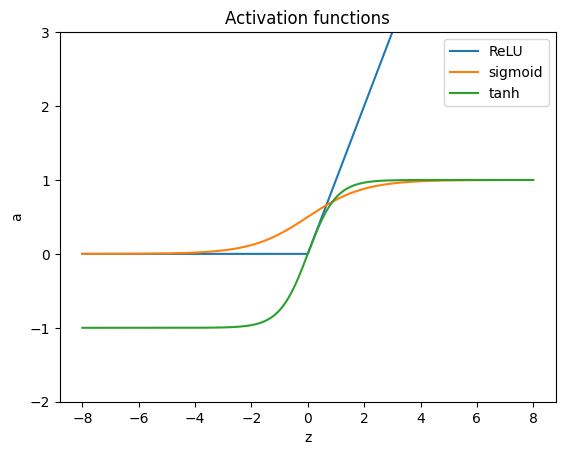

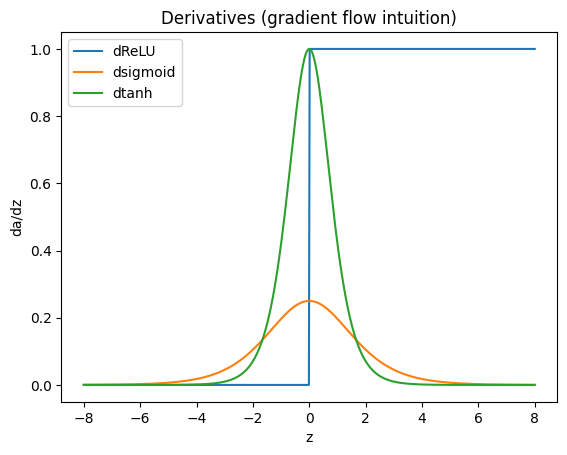

Derivative ranges:
dsigmoid min/max: 0.00033523767075636815 0.24998885209046676
dtanh    min/max: 4.5014059768533343e-07 0.9998216493537179


In [13]:
z = np.linspace(-8, 8, 600)

# Plot 1: activations
plt.figure()
plt.plot(z, relu(z), label='ReLU')
plt.plot(z, sigmoid(z), label='sigmoid')
plt.plot(z, tanh(z), label='tanh')
plt.title('Activation functions')
plt.xlabel('z')
plt.ylabel('a')
plt.ylim(-2, 3)
plt.legend()
plt.show()

# Plot 2: derivatives
plt.figure()
plt.plot(z, drelu(z), label='dReLU')
plt.plot(z, dsigmoid(z), label='dsigmoid')
plt.plot(z, dtanh(z), label='dtanh')
plt.title('Derivatives (gradient flow intuition)')
plt.xlabel('z')
plt.ylabel('da/dz')
plt.legend()
plt.show()

print('Derivative ranges:')
print('dsigmoid min/max:', dsigmoid(z).min(), dsigmoid(z).max())
print('dtanh    min/max:', dtanh(z).min(), dtanh(z).max())

In [14]:
# 4) Pairing examples

# Regression pairing: identity output + MSE/MAE
x_reg = rng.normal(0, 1.0, size=(50,1))
y_reg = 2.0*x_reg + 0.3 + 0.1*rng.normal(size=(50,1))
a_reg = 2.0*x_reg + 0.3
print('Regression MSE:', float(mse(a_reg, y_reg)))
print('Regression MAE:', float(mae(a_reg, y_reg)))

# Binary classification pairing: logits -> BCE-from-logits (stable)
x_bin = rng.normal(0, 1.0, size=(80,2))
W = np.array([[1.2], [-0.7]])
b = np.array([[0.1]])
z_bin = x_bin @ W + b
y_bin = (z_bin > 0).astype(float)
print('Binary BCE-from-logits:', float(bce_from_logits(z_bin, y_bin)))


Regression MSE: 0.006126801671383968
Regression MAE: 0.0654071585861028
Binary BCE-from-logits: 0.3453894802127911


## Reflection questions
1. Where do sigmoid/tanh derivatives become small, and why does that matter?
2. Why does ReLU avoid saturation for positive logits?
3. Why is “CE from logits” preferable to “softmax then log” numerically?
4. Which loss is more robust to outliers: MAE or MSE, and why?
5. What goes wrong if you use MSE for classification probabilities?

## Optional extensions
1. Implement leaky ReLU and compare derivative behavior.
2. Plot BCE as a function of logit `z` for `y=0` and `y=1`.
3. Implement label smoothing for multiclass CE and test its effect on loss.

## Summary
- Activations shape both outputs and gradient flow.
- Sigmoid/tanh can saturate; ReLU is piecewise-linear.
- Loss must match the output semantics.
- Stable implementations (from logits) prevent NaNs/overflow.
- Next: generalization behavior (overfitting vs underfitting).